Run on NERSC

In [1]:
from __future__ import division, print_function
import sys, os, glob, time, warnings, gc
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table, vstack, hstack
import fitsio
from astropy.io import fits

from scipy.optimize import root_scalar

In [2]:
params = {'legend.fontsize': 'large',
         'axes.labelsize': 'large',
         'axes.titlesize':'large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large',
         'figure.facecolor':'w'} 
plt.rcParams.update(params)

In [3]:
from scipy.optimize import curve_fit

def get_frac_moffat(r, alpha, beta):
    """
    Calculate the fraction of light within radius r of a Moffat profile.
    """    
    frac = 1 - alpha**(2*(beta-1))*(alpha**2 + r**2)**(1-beta)
    return(frac)

def get_sb_moffat(r, alpha, beta):
    """
    Calculate the surface brightness of light at radius r of a Moffat profile.
    The integral (i.e., total flux) is unity by definition.
    """
    i = (beta-1)/(np.pi * alpha**2)*(1 + (r/alpha)**2)**(-beta)
    return i

def get_sb_moffat_plus_power_law(r, alpha1, beta1, plexp2, weight2):
    """
    Calculate the surface brightness of light at radius r of the sum of two Moffat profiles.
    The integral (i.e., total flux) is NOT unity.
    """
    i = (beta1-1)/(np.pi * alpha1**2)*(1 + (r/alpha1)**2)**(-beta1) \
        + weight2 *r**(plexp2)
    return i

def get_sb_double_moffat(r, alpha1, beta1, alpha2, beta2, weight2):
    """
    Calculate the surface brightness of light at radius r of the sum of two Moffat profiles.
    The integral (i.e., total flux) is NOT unity.
    """
    i = (beta1-1)/(np.pi * alpha1**2)*(1 + (r/alpha1)**2)**(-beta1) \
        + weight2 * (beta2-1)/(np.pi * alpha2**2)*(1 + (r/alpha2)**2)**(-beta2)
    return i

In [4]:
params = {
'g_weight2': 0.00045, 'g_plexp2': -2.,
'r_weight2': 0.00033, 'r_plexp2': -2.,
'z_alpha2': 17.650, 'z_beta2': 1.7, 'z_weight2': 0.0145,
}

outlier_ccd_list = ['N20', 'S8', 'S10', 'S18', 'S21', 'S27']
params_outlier = {'z_alpha2': 16, 'z_beta2': 2.3, 'z_weight2': 0.0095}

field = 'south'
region_name = 'decals_ngc'
pixscale = 0.262

__Plot the PSF profiles (normalized to a 22.5 magnitude star)__

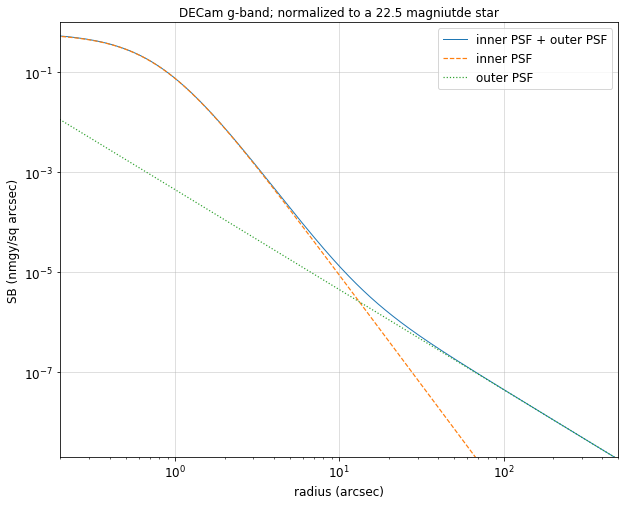

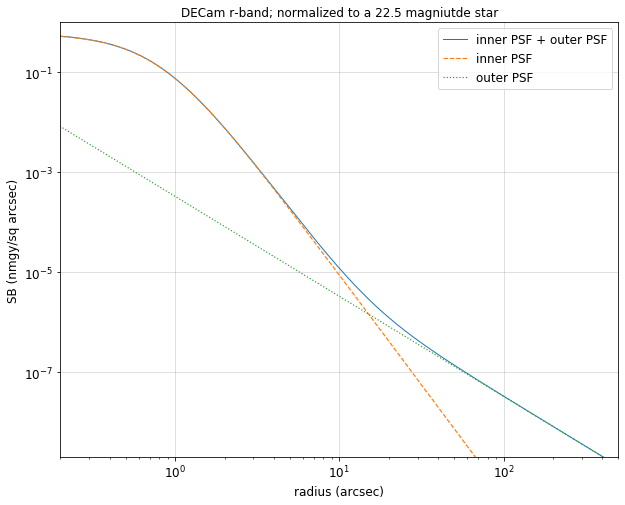

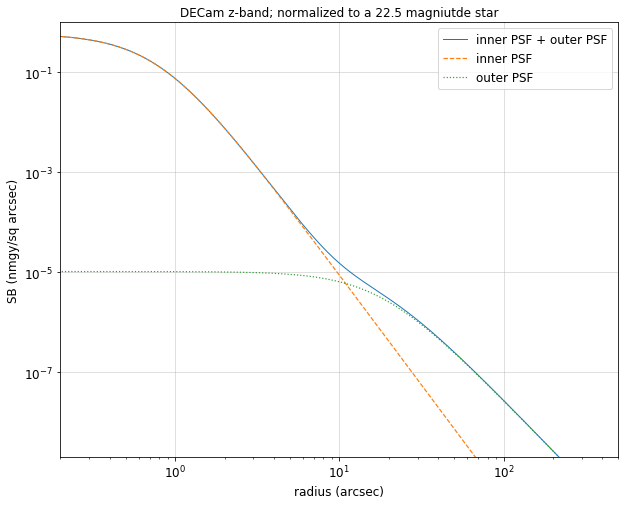

In [5]:
radius = np.logspace(-1, np.log10(500), 1000)

for band in ['g', 'r', 'z']:
    
    alpha, beta = 0.8, 2.2 # using default values
    
    # nanomaggies per sq arcsec:
    if band!='z':
        plexp2, weight2 = params[band+'_plexp2'], params[band+'_weight2']
        flux_all = get_sb_moffat_plus_power_law(radius, alpha, beta, plexp2, weight2)
        flux_inner = get_sb_moffat(radius, alpha, beta)
        flux_outer = weight2 * radius**(plexp2)
    else:
        alpha2, beta2, weight2 = params[band+'_alpha2'], params[band+'_beta2'],  params[band+'_weight2']
        flux_all = get_sb_double_moffat(radius, alpha, beta, alpha2, beta2, weight2)
        flux_inner = get_sb_moffat(radius, alpha, beta)
        flux_outer = weight2 * get_sb_moffat(radius, alpha2, beta2)

    plt.figure(figsize=(10, 8))
    plt.loglog(radius, flux_all, '-', lw=1, label='inner PSF + outer PSF')
    plt.loglog(radius, flux_inner, '--', lw=1.2, alpha=1., label='inner PSF')
    plt.loglog(radius, flux_outer, ':', lw=1.2, alpha=1., label='outer PSF')
    plt.axis([0.2, 500, 2e-9, 1.])
    plt.grid(alpha=0.5)
    plt.title('DECam {}-band; normalized to a 22.5 magniutde star'.format(band))
    plt.xlabel('radius (arcsec)')
    plt.ylabel('SB (nmgy/sq arcsec)')
    plt.legend(markerscale=7)
    plt.show()

__Plot the radius-magnitude relation (which is the inverse of the PSF profiles)__

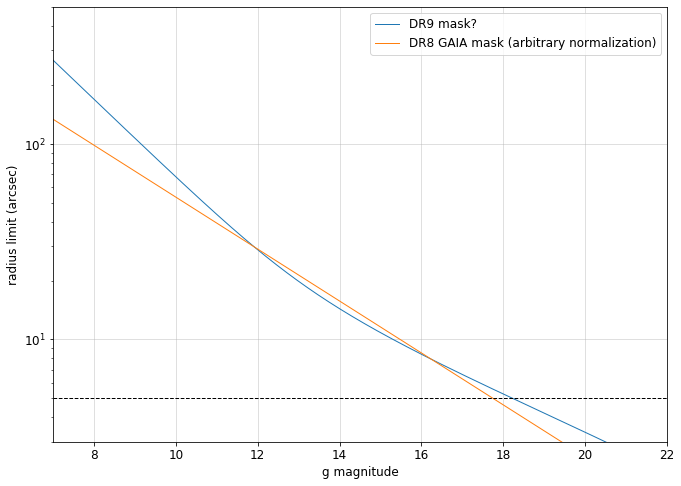

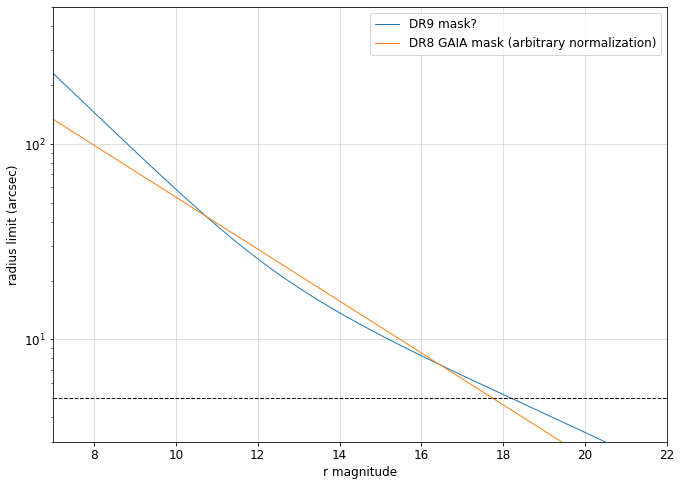

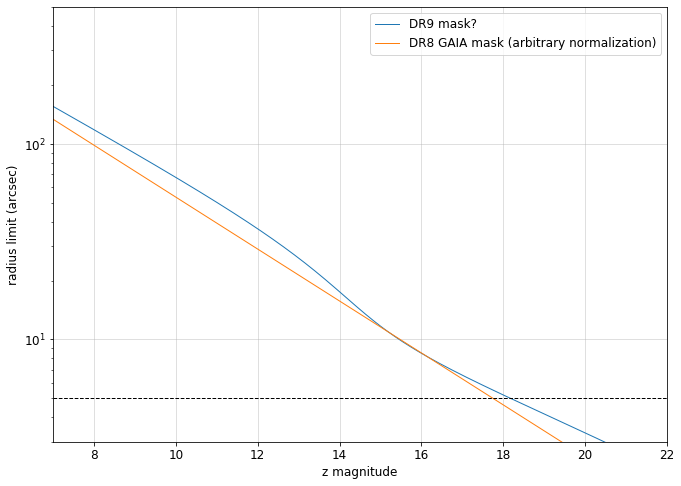

In [6]:
radius = np.logspace(-1, np.log10(500), 1000)

sb_limit_in_mag = 27.5
sb_limit_in_nmgy = 10**((22.5-sb_limit_in_mag)/2.5)

for band in ['g', 'r', 'z']:
    
    # nanomaggies per sq arcsec:
    if band!='z':
        plexp2, weight2 = params[band+'_plexp2'], params[band+'_weight2']
        flux_all = get_sb_moffat_plus_power_law(radius, alpha, beta, plexp2, weight2)
        flux_inner = get_sb_moffat(radius, alpha, beta)
        flux_outer = weight2 * radius**(plexp2)
    else:
        alpha2, beta2, weight2 = params[band+'_alpha2'], params[band+'_beta2'],  params[band+'_weight2']
        flux_all = get_sb_double_moffat(radius, alpha, beta, alpha2, beta2, weight2)
        flux_inner = get_sb_moffat(radius, alpha, beta)
        flux_outer = weight2 * get_sb_moffat(radius, alpha2, beta2)

    mag_at_radius = 22.5+2.5*np.log10(flux_all/sb_limit_in_nmgy)
    
    # compare with DR8 GAIA mask
    gaia_radius = np.minimum(1800., 150. * 2.5**((11. - mag_at_radius)/3.)) * 0.262
    
    plt.figure(figsize=(11, 8))
    plt.semilogy(mag_at_radius, radius, '-', lw=1, label='DR9 mask?')
    plt.semilogy(mag_at_radius, gaia_radius, '-', lw=1, label='DR8 GAIA mask (arbitrary normalization)')
    plt.grid(alpha=0.5)
    # plt.title(' ')
    plt.xlabel('{} magnitude'.format(band))
    plt.ylabel('radius limit (arcsec)')
    plt.axhline(5., lw=1, ls='--', color='k')
    plt.axis([7, 22, 3, 500])
    plt.legend()
    plt.show()

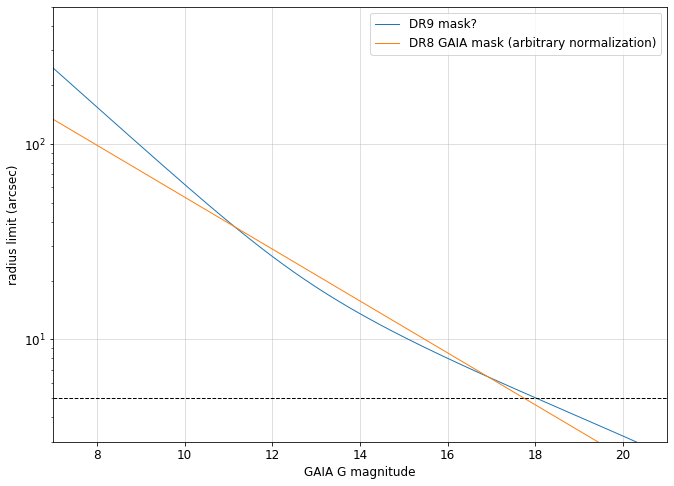

In [7]:
band = 'g'
mag_offset = 0.2 # almost all stars are at least 0.2 mag fainter in DECam_g than GAIA_G

radius = np.logspace(-1, np.log10(500), 1000)

sb_limit_in_mag = 27.5
sb_limit_in_nmgy = 10**((22.5-sb_limit_in_mag)/2.5)

# nanomaggies per sq arcsec:
if band!='z':
    plexp2, weight2 = params[band+'_plexp2'], params[band+'_weight2']
    flux_all = get_sb_moffat_plus_power_law(radius, alpha, beta, plexp2, weight2)
    flux_inner = get_sb_moffat(radius, alpha, beta)
    flux_outer = weight2 * radius**(plexp2)
else:
    alpha2, beta2, weight2 = params[band+'_alpha2'], params[band+'_beta2'],  params[band+'_weight2']
    flux_all = get_sb_double_moffat(radius, alpha, beta, alpha2, beta2, weight2)
    flux_inner = get_sb_moffat(radius, alpha, beta)
    flux_outer = weight2 * get_sb_moffat(radius, alpha2, beta2)

mag_at_radius = 22.5+2.5*np.log10(flux_all/sb_limit_in_nmgy)
mag_at_radius -= mag_offset # convert to GAIA-G

# compare with DR8 GAIA mask
gaia_radius = np.minimum(1800., 150. * 2.5**((11. - mag_at_radius)/3.)) * 0.262

plt.figure(figsize=(11, 8))
plt.semilogy(mag_at_radius, radius, '-', lw=1, label='DR9 mask?')
plt.semilogy(mag_at_radius, gaia_radius, '-', lw=1, label='DR8 GAIA mask (arbitrary normalization)')
plt.grid(alpha=0.5)
# plt.title(' ')
plt.xlabel('GAIA G magnitude')
plt.ylabel('radius limit (arcsec)')
plt.axhline(5., lw=1, ls='--', color='k')
plt.axis([7, 21, 3, 500])
plt.legend()
plt.show()

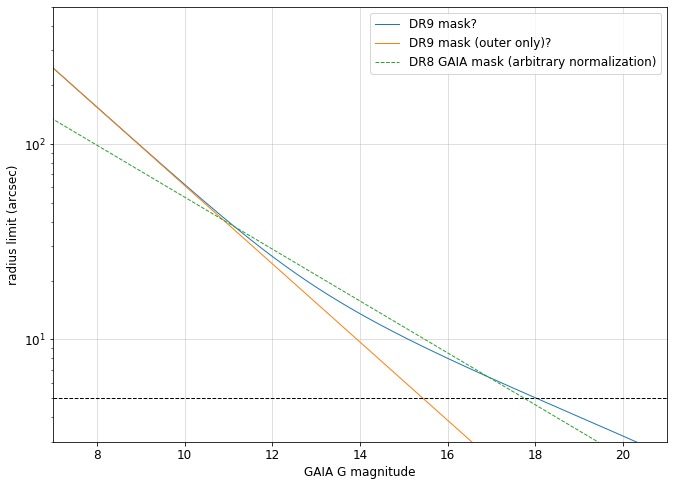

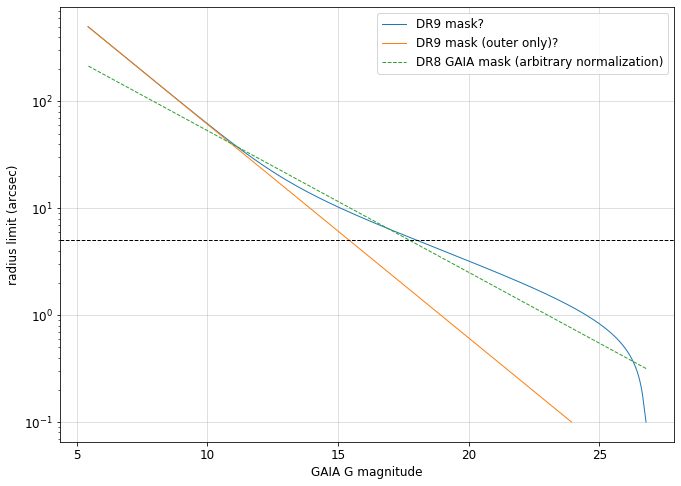

In [8]:
band = 'g'
mag_offset = 0.2 # almost all stars are at least 0.2 mag fainter in DECam_g than GAIA_G

radius = np.logspace(-1, np.log10(500), 1000)

sb_limit_in_mag = 27.5
sb_limit_in_nmgy = 10**((22.5-sb_limit_in_mag)/2.5)

# nanomaggies per sq arcsec:
if band!='z':
    plexp2, weight2 = params[band+'_plexp2'], params[band+'_weight2']
    flux_all = get_sb_moffat_plus_power_law(radius, alpha, beta, plexp2, weight2)
    flux_inner = get_sb_moffat(radius, alpha, beta)
    flux_outer = weight2 * radius**(plexp2)
else:
    alpha2, beta2, weight2 = params[band+'_alpha2'], params[band+'_beta2'],  params[band+'_weight2']
    flux_all = get_sb_double_moffat(radius, alpha, beta, alpha2, beta2, weight2)
    flux_inner = get_sb_moffat(radius, alpha, beta)
    flux_outer = weight2 * get_sb_moffat(radius, alpha2, beta2)

mag_at_radius = 22.5+2.5*np.log10(flux_all/sb_limit_in_nmgy)
mag_at_radius -= mag_offset # convert to GAIA-G

mag_at_radius_outer = 22.5+2.5*np.log10(flux_outer/sb_limit_in_nmgy)
mag_at_radius_outer -= mag_offset # convert to GAIA-G

# compare with DR8 GAIA mask
gaia_radius = np.minimum(1800., 150. * 2.5**((11. - mag_at_radius)/3.)) * 0.262

plt.figure(figsize=(11, 8))
plt.semilogy(mag_at_radius, radius, '-', lw=1, label='DR9 mask?')
plt.semilogy(mag_at_radius_outer, radius, '-', lw=1, label='DR9 mask (outer only)?')
plt.semilogy(mag_at_radius, gaia_radius, '--', lw=1, label='DR8 GAIA mask (arbitrary normalization)')
plt.grid(alpha=0.5)
# plt.title(' ')
plt.xlabel('GAIA G magnitude')
plt.ylabel('radius limit (arcsec)')
plt.axhline(5., lw=1, ls='--', color='k')
plt.axis([7, 21, 3, 500])
plt.legend()
plt.show()

plt.figure(figsize=(11, 8))
plt.semilogy(mag_at_radius, radius, '-', lw=1, label='DR9 mask?')
plt.semilogy(mag_at_radius_outer, radius, '-', lw=1, label='DR9 mask (outer only)?')
plt.semilogy(mag_at_radius, gaia_radius, '--', lw=1, label='DR8 GAIA mask (arbitrary normalization)')
plt.grid(alpha=0.5)
# plt.title(' ')
plt.xlabel('GAIA G magnitude')
plt.ylabel('radius limit (arcsec)')
plt.axhline(5., lw=1, ls='--', color='k')
# plt.axis([7, 21, 3, 500])
plt.legend()
plt.show()